### 数据处理 - 划分文件
- 原始数据集直接从Kaggle上下载，解压后train目录下一共有25000张图片，test目录下一共有12500张图片
- 我们需要通过Keras ImageDataGenerator的flow_from_directory方法来加载我们的图片，所以我们需要将训练集和测试集的图片放到子文件夹中
- 测试集很简单，建一个子目录，将文件全部移动过去就行
- 训练集需要建立两个子目录，将狗和猫的图片分别移动到两个子目录中去
- 训练集中的图片名称格式为{种类}.序号.jpg，比如 cat.1.jpg 或 dog.1.jpg。我们可以利用命名规则来移动训练集的图片

当前的图片目录结构如下
```
data
 ├── test   [12500 images]
 └── train  [25000 images]
```
预处理后图片目录结构如下
```
data
 ├── test
 │   └── none [12500 images]
 └── train
     ├── cat  [12500 images]
     └── dog  [12500 images]
```

In [10]:
# 数据处理代码
import os
from shutil import move

train_src = 'data/train/'
test_src = 'data/test/'
dog_dest = 'data/train/dog/'
cat_dest = 'data/train/cat/'
test_dest = 'data/test/none/'

#创建子目录
os.makedirs(dog_dest, exist_ok=True)
os.makedirs(cat_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)

#移动测试图片至子文件夹中
for root, dirs, files in os.walk(test_src):
    if(root == test_src):
        for name in files:
            if(name.find('jpg')>-1):
                move(test_src + name, test_dest + name)

#移动训练集图片至对应的子文件夹中
for root, dirs, files in os.walk(train_src):
    if(root == train_src):
        for name in files:
            if(name.find('jpg')>-1 and name.find('cat')>-1):
                move(train_src + name, cat_dest + name)
            elif(name.find('jpg')>-1 and name.find('dog')>-1):
                move(train_src + name, dog_dest + name)
            else:
                pass

print("cat images: ", 
      len([name for name in os.listdir(cat_dest) if os.path.isfile(os.path.join(cat_dest, name))]))
print("dog images: ", 
      len([name for name in os.listdir(dog_dest) if os.path.isfile(os.path.join(dog_dest, name))]))
print("test images: ", 
      len([name for name in os.listdir(test_dest) if os.path.isfile(os.path.join(test_dest, name))]))

cat images:  12500
dog images:  12500
test images:  12500


###   数据处理 - 查找异常图片
- 利用Xception模型来对训练集的图片做预测，找到那些既不属于猫也不属于狗的图片
- 定义了2个数组，包含了所有属于狗和猫的标签
- 定义了方法 predict_top_20，预测并返回排名前20的标签
- 定义了方法 is_any_matched_labels，查看模型预测的top20的标签是否包含在猫或狗的标签中
- 定义了方法 find_noise_image，通过调用方法 predict_top_20 和方法 is_any_matched_labels，查找异常图片
- 考虑到本机性能问题，这里猫和狗的数据分成了2个批次来跑
- 找到可能为异常的图片后，分别把这些异常图片拷贝到另外2个文件夹中方便后续分析

In [2]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

dogs = ['n02085620','n02085782','n02085936','n02086079'
        ,'n02086240','n02086646','n02086910','n02087046'
        ,'n02087394','n02088094','n02088238','n02088364'
        ,'n02088466','n02088632','n02089078','n02089867'
        ,'n02089973','n02090379','n02090622','n02090721'
        ,'n02091032','n02091134','n02091244','n02091467'
        ,'n02091635','n02091831','n02092002','n02092339'
        ,'n02093256','n02093428','n02093647','n02093754'
        ,'n02093859','n02093991','n02094114','n02094258'
        ,'n02094433','n02095314','n02095570','n02095889'
        ,'n02096051','n02096177','n02096294','n02096437'
        ,'n02096585','n02097047','n02097130','n02097209'
        ,'n02097298','n02097474','n02097658','n02098105'
        ,'n02098286','n02098413','n02099267','n02099429'
        ,'n02099601','n02099712','n02099849','n02100236'
        ,'n02100583','n02100735','n02100877','n02101006'
        ,'n02101388','n02101556','n02102040','n02102177'
        ,'n02102318','n02102480','n02102973','n02104029'
        ,'n02104365','n02105056','n02105162','n02105251'
        ,'n02105412','n02105505','n02105641','n02105855'
        ,'n02106030','n02106166','n02106382','n02106550'
        ,'n02106662','n02107142','n02107312','n02107574'
        ,'n02107683','n02107908','n02108000','n02108089'
        ,'n02108422','n02108551','n02108915','n02109047'
        ,'n02109525','n02109961','n02110063','n02110185'
        ,'n02110341','n02110627','n02110806','n02110958'
        ,'n02111129','n02111277','n02111500','n02111889'
        ,'n02112018','n02112137','n02112350','n02112706'
        ,'n02113023','n02113186','n02113624','n02113712'
        ,'n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

# 根据图片路径，模型等，返回前二十的预测
def predict_top_20(image_path, model, input_shape, preprocess):    
    # load image and do preprocess
    img = load_img(image_path, target_size=input_shape)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess(x)
    # predict and return decoded predictions
    preds = model.predict(x)
    return imagenet_utils.decode_predictions(preds, top=20)

# 判断前二十中是否有预测值在对应的标签中
def is_any_matched_labels(pred, labels):
    for i in range(len(pred[0])): 
        if any(pred[0][i][0] in s for s in labels):
            return True
    return False

# 查找异常图片
def find_noise_image(Model, image_type, start_index, end_index):
    start_time = time.time()
    image_path = 'data/train/'
    labels = []
    noise_images = []
    model = Model(weights='imagenet')
    if(image_type == 'cat'):
        image_path = image_path + 'cat/cat.{}.jpg'
        labels = cats
    elif(image_type == 'dog'):
        image_path = image_path + 'dog/dog.{}.jpg'
        labels = dogs
    else:
        raise ValueError("image type is not correct!")
    
    for i in range(start_index, end_index+1):
        cur_image_path = image_path.format(i)
        preds = predict_top_20(cur_image_path, model, (299,299), xception.preprocess_input)
        is_match = is_any_matched_labels(preds, labels)
        # if not match record image path
        if (not is_match):
            noise_images.append(cur_image_path)
            
    consumed_time = time.time() - start_time
    print("Found noise images: {} and consumed time {:.2f} seconds".format(noise_images, consumed_time))
    return noise_images

In [14]:
# 在猫的训练集中查找异常图片(范围：1-6000)
noise_images1 = find_noise_image(Xception, 'cat', 1, 6000)

Found noise images: ['data/train/cat/cat.221.jpg', 'data/train/cat/cat.252.jpg', 'data/train/cat/cat.372.jpg', 'data/train/cat/cat.503.jpg', 'data/train/cat/cat.519.jpg', 'data/train/cat/cat.587.jpg', 'data/train/cat/cat.599.jpg', 'data/train/cat/cat.724.jpg', 'data/train/cat/cat.883.jpg', 'data/train/cat/cat.933.jpg', 'data/train/cat/cat.1282.jpg', 'data/train/cat/cat.1741.jpg', 'data/train/cat/cat.2150.jpg', 'data/train/cat/cat.2279.jpg', 'data/train/cat/cat.2337.jpg', 'data/train/cat/cat.2429.jpg', 'data/train/cat/cat.2433.jpg', 'data/train/cat/cat.2457.jpg', 'data/train/cat/cat.2520.jpg', 'data/train/cat/cat.2663.jpg', 'data/train/cat/cat.2737.jpg', 'data/train/cat/cat.2817.jpg', 'data/train/cat/cat.2835.jpg', 'data/train/cat/cat.2893.jpg', 'data/train/cat/cat.2939.jpg', 'data/train/cat/cat.3099.jpg', 'data/train/cat/cat.3105.jpg', 'data/train/cat/cat.3123.jpg', 'data/train/cat/cat.3216.jpg', 'data/train/cat/cat.3658.jpg', 'data/train/cat/cat.3672.jpg', 'data/train/cat/cat.3731.jpg

In [15]:
# 在猫的训练集中查找异常图片(范围：6001-12499)
noise_images2 = find_noise_image(Xception, 'cat', 6001, 12499)

Found noise images: ['data/train/cat/cat.6263.jpg', 'data/train/cat/cat.6348.jpg', 'data/train/cat/cat.6402.jpg', 'data/train/cat/cat.6429.jpg', 'data/train/cat/cat.6442.jpg', 'data/train/cat/cat.6590.jpg', 'data/train/cat/cat.6655.jpg', 'data/train/cat/cat.6696.jpg', 'data/train/cat/cat.6699.jpg', 'data/train/cat/cat.6987.jpg', 'data/train/cat/cat.7194.jpg', 'data/train/cat/cat.7206.jpg', 'data/train/cat/cat.7377.jpg', 'data/train/cat/cat.7411.jpg', 'data/train/cat/cat.7429.jpg', 'data/train/cat/cat.7487.jpg', 'data/train/cat/cat.7564.jpg', 'data/train/cat/cat.7599.jpg', 'data/train/cat/cat.7604.jpg', 'data/train/cat/cat.7682.jpg', 'data/train/cat/cat.7703.jpg', 'data/train/cat/cat.7730.jpg', 'data/train/cat/cat.7920.jpg', 'data/train/cat/cat.7968.jpg', 'data/train/cat/cat.8087.jpg', 'data/train/cat/cat.8286.jpg', 'data/train/cat/cat.8383.jpg', 'data/train/cat/cat.8456.jpg', 'data/train/cat/cat.8470.jpg', 'data/train/cat/cat.8921.jpg', 'data/train/cat/cat.9090.jpg', 'data/train/cat/ca

In [19]:
# 在狗的训练集中查找异常图片(范围：1-6000)
noise_images3 = find_noise_image(Xception, 'dog', 1, 6000)

Found noise images: ['data/train/dog/dog.1194.jpg', 'data/train/dog/dog.1259.jpg', 'data/train/dog/dog.1308.jpg', 'data/train/dog/dog.1773.jpg', 'data/train/dog/dog.1895.jpg', 'data/train/dog/dog.2422.jpg', 'data/train/dog/dog.2614.jpg', 'data/train/dog/dog.3889.jpg', 'data/train/dog/dog.4367.jpg', 'data/train/dog/dog.5604.jpg'] and consumed time 172.78 seconds


In [20]:
# 在狗的训练集中查找异常图片(范围：6001-12499)
noise_images4 = find_noise_image(Xception, 'dog', 6001, 12499)

Found noise images: ['data/train/dog/dog.6475.jpg', 'data/train/dog/dog.6725.jpg', 'data/train/dog/dog.8736.jpg', 'data/train/dog/dog.8898.jpg', 'data/train/dog/dog.9188.jpg', 'data/train/dog/dog.9517.jpg', 'data/train/dog/dog.10161.jpg', 'data/train/dog/dog.10190.jpg', 'data/train/dog/dog.10237.jpg', 'data/train/dog/dog.10747.jpg', 'data/train/dog/dog.10801.jpg', 'data/train/dog/dog.11299.jpg', 'data/train/dog/dog.12148.jpg', 'data/train/dog/dog.12155.jpg', 'data/train/dog/dog.12376.jpg'] and consumed time 185.24 seconds


In [3]:
# 创建2个文件夹，noise_cat和 noise_dog，将Xception认为有异常的图片拷贝一份过去
import os
from shutil import copy

dog_noise_dest = 'data/train/noise_dog/'
cat_noise_dest = 'data/train/noise_cat/'

#创建子目录
os.makedirs(dog_noise_dest, exist_ok=True)
os.makedirs(cat_noise_dest, exist_ok=True)

# 合并cat文件数组
cat_noise_images = np.concatenate((noise_images1, noise_images2), axis=0)
# 合并dog文件数组
dog_noise_images = np.concatenate((noise_images3, noise_images4), axis=0)

# 拷贝猫的noise图片
for fname in cat_noise_images:
    index = int(fname[fname.find('.')+1:fname.rfind('.')])
    copy(fname, cat_noise_dest + 'cat.' + str(index) + ".jpg") 
    
# 拷贝狗的noise图片
for fname in dog_noise_images:
    index = int(fname[fname.find('.')+1:fname.rfind('.')])
    copy(fname, dog_noise_dest + 'dog.' + str(index) + ".jpg")

###   数据处理 - 分析并处理异常图片
- 可能为异常的图片拷贝到了另外2个文件夹并且图片数量并不是非常多，可以先用肉眼判断一下这些图片
- 看过异常图片后发现，猫的图片有大部分都误判了，狗的图片大部分判断正确
- 我们只“倾听了”一个模型Xception的“声音”，为了降低误判我们可以选择多“听听”几个模型的声音
- 我选择用排除法，在可能为异常的图片中去排除那些正常的图片，这样做的好处是节省时间，比较直接
- 因为狗的图片大部分正确，少数几张误判，最后可以手动移除，所以下面只会对猫的异常图片进行排除法

In [4]:
# 定义方法 has_cat 根据模型判断传入的文件数组中是否可能有猫
def has_cat(files, Model, input_shape, preprocss):
    start_time = time.time()
    images = []
    model = Model(weights='imagenet') # load model
    
    for f in files:
        preds = predict_top_20(f, model, input_shape, preprocss)
        is_match = is_any_matched_labels(preds, cats)
        # if match record add file path
        if (is_match):
            images.append(f)
            
    consumed_time = time.time() - start_time
    print("Found images: {} and consumed time {:.2f} seconds".format(images, consumed_time))
    return images

In [52]:
# 利用InceptionV3模型在异常数据中做预测，找出可能为猫的图片
cat_images_inception = has_cat(cat_noise_images, InceptionV3, (299, 299), inception_v3.preprocess_input)

Found images: ['data/train/cat/cat.221.jpg', 'data/train/cat/cat.519.jpg', 'data/train/cat/cat.587.jpg', 'data/train/cat/cat.599.jpg', 'data/train/cat/cat.724.jpg', 'data/train/cat/cat.933.jpg', 'data/train/cat/cat.1282.jpg', 'data/train/cat/cat.2737.jpg', 'data/train/cat/cat.2835.jpg', 'data/train/cat/cat.3099.jpg', 'data/train/cat/cat.3123.jpg', 'data/train/cat/cat.4190.jpg', 'data/train/cat/cat.4308.jpg', 'data/train/cat/cat.4629.jpg', 'data/train/cat/cat.5472.jpg', 'data/train/cat/cat.5492.jpg', 'data/train/cat/cat.5795.jpg', 'data/train/cat/cat.5804.jpg', 'data/train/cat/cat.6263.jpg', 'data/train/cat/cat.6348.jpg', 'data/train/cat/cat.6696.jpg', 'data/train/cat/cat.7206.jpg', 'data/train/cat/cat.7604.jpg', 'data/train/cat/cat.8087.jpg', 'data/train/cat/cat.8286.jpg', 'data/train/cat/cat.9144.jpg', 'data/train/cat/cat.9189.jpg', 'data/train/cat/cat.9250.jpg', 'data/train/cat/cat.9494.jpg', 'data/train/cat/cat.9596.jpg', 'data/train/cat/cat.9695.jpg', 'data/train/cat/cat.10176.jpg'

In [53]:
# 利用ResNet50模型在异常数据中做预测，找出可能为猫的图片
cat_images_resnet50 = has_cat(cat_noise_images, ResNet50, (224, 224), resnet50.preprocess_input)

Found images: ['data/train/cat/cat.221.jpg', 'data/train/cat/cat.519.jpg', 'data/train/cat/cat.1282.jpg', 'data/train/cat/cat.1741.jpg', 'data/train/cat/cat.2279.jpg', 'data/train/cat/cat.2433.jpg', 'data/train/cat/cat.3099.jpg', 'data/train/cat/cat.3845.jpg', 'data/train/cat/cat.4085.jpg', 'data/train/cat/cat.4629.jpg', 'data/train/cat/cat.5347.jpg', 'data/train/cat/cat.5492.jpg', 'data/train/cat/cat.5527.jpg', 'data/train/cat/cat.6263.jpg', 'data/train/cat/cat.6696.jpg', 'data/train/cat/cat.6987.jpg', 'data/train/cat/cat.7194.jpg', 'data/train/cat/cat.7682.jpg', 'data/train/cat/cat.7703.jpg', 'data/train/cat/cat.7730.jpg', 'data/train/cat/cat.8286.jpg', 'data/train/cat/cat.9189.jpg', 'data/train/cat/cat.9589.jpg', 'data/train/cat/cat.10176.jpg', 'data/train/cat/cat.10209.jpg', 'data/train/cat/cat.10266.jpg', 'data/train/cat/cat.10579.jpg', 'data/train/cat/cat.10893.jpg', 'data/train/cat/cat.11194.jpg', 'data/train/cat/cat.11237.jpg', 'data/train/cat/cat.11413.jpg'] and consumed time 

In [5]:
# 合并InceptionV3和ResNet50的数据
cat_images_incepetion_resnet = np.concatenate((cat_images_inception, cat_images_resnet50), axis=0)
# 去重
cat_images_incepetion_resnet = list(set(cat_images_incepetion_resnet))

In [6]:
# 定义方法 remove_from_noise，从异常图片中移除正常的图片
def remove_from_noise(noise_images, not_noise_images):
    to_be_removed_index = []
    # 获取误判文件的索引
    for idx,fname in enumerate(noise_images):
        if(fname in not_noise_images):
            to_be_removed_index.append(idx)
    # 根据索引删除掉误判的图片
    return np.delete(noise_images, to_be_removed_index)

# 首先移除InceptionV3和ResNet50判断正常的图片
cat_noise_images_filtered = remove_from_noise(cat_noise_images, cat_images_incepetion_resnet)

# 打出剩下的异常图片并用肉眼来识别
print(cat_noise_images_filtered)

['data/train/cat/cat.252.jpg' 'data/train/cat/cat.372.jpg'
 'data/train/cat/cat.503.jpg' 'data/train/cat/cat.883.jpg'
 'data/train/cat/cat.2150.jpg' 'data/train/cat/cat.2337.jpg'
 'data/train/cat/cat.2429.jpg' 'data/train/cat/cat.2457.jpg'
 'data/train/cat/cat.2520.jpg' 'data/train/cat/cat.2663.jpg'
 'data/train/cat/cat.2817.jpg' 'data/train/cat/cat.2893.jpg'
 'data/train/cat/cat.2939.jpg' 'data/train/cat/cat.3105.jpg'
 'data/train/cat/cat.3216.jpg' 'data/train/cat/cat.3658.jpg'
 'data/train/cat/cat.3672.jpg' 'data/train/cat/cat.3731.jpg'
 'data/train/cat/cat.3766.jpg' 'data/train/cat/cat.3868.jpg'
 'data/train/cat/cat.4338.jpg' 'data/train/cat/cat.4688.jpg'
 'data/train/cat/cat.4833.jpg' 'data/train/cat/cat.4852.jpg'
 'data/train/cat/cat.5071.jpg' 'data/train/cat/cat.5324.jpg'
 'data/train/cat/cat.5351.jpg' 'data/train/cat/cat.5355.jpg'
 'data/train/cat/cat.5418.jpg' 'data/train/cat/cat.5534.jpg'
 'data/train/cat/cat.5609.jpg' 'data/train/cat/cat.5820.jpg'
 'data/train/cat/cat.6402.jp

Length of cat noise images 14, length of dog noise images 13


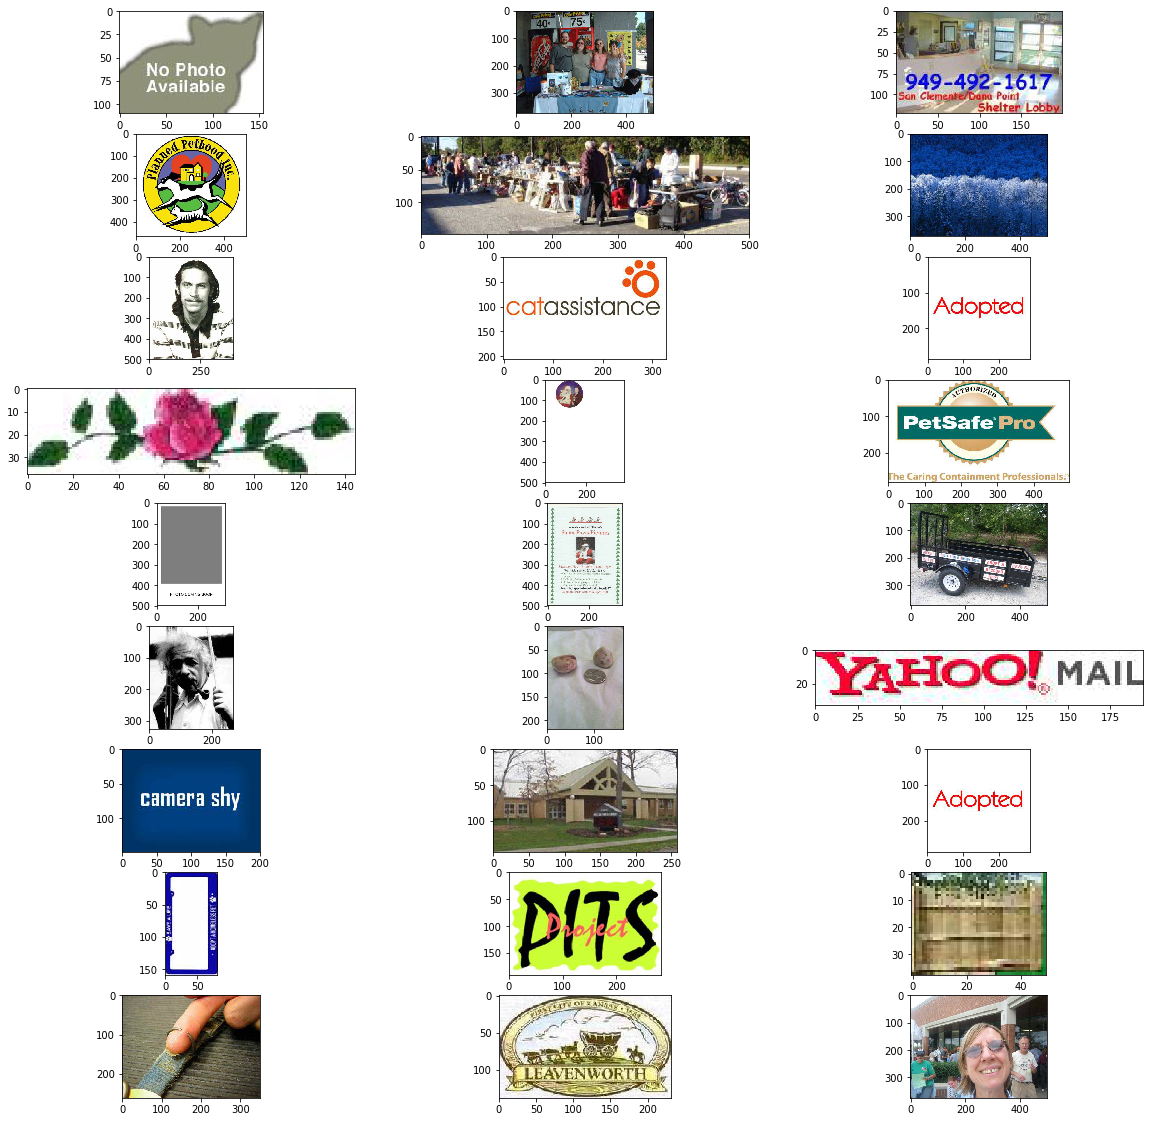

In [7]:
from shutil import rmtree
from shutil import move

# 模型并不是完美的，猫和狗的图片仍有部分误判，通过肉眼判断并手动定义了以下正常图片的数组
cat_images_by_human = ['data/train/cat/cat.883.jpg','data/train/cat/cat.2150.jpg',
                      'data/train/cat/cat.2429.jpg','data/train/cat/cat.2939.jpg',
                      'data/train/cat/cat.3105.jpg','data/train/cat/cat.4833.jpg',
                      'data/train/cat/cat.4852.jpg','data/train/cat/cat.6590.jpg',
                      'data/train/cat/cat.6655.jpg','data/train/cat/cat.6590.jpg',
                      'data/train/cat/cat.7411.jpg','data/train/cat/cat.7429.jpg',
                      'data/train/cat/cat.7487.jpg','data/train/cat/cat.7968.jpg',
                      'data/train/cat/cat.8383.jpg','data/train/cat/cat.8470.jpg',
                      'data/train/cat/cat.7487.jpg','data/train/cat/cat.10365.jpg',
                      'data/train/cat/cat.10532.jpg','data/train/cat/cat.10636.jpg',
                      'data/train/cat/cat.10864.jpg','data/train/cat/cat.11231.jpg',
                      'data/train/cat/cat.11565.jpg','data/train/cat/cat.11607.jpg',
                      'data/train/cat/cat.11879.jpg','data/train/cat/cat.12227.jpg',
                      'data/train/cat/cat.12424.jpg','data/train/cat/cat.12431.jpg',
                      'data/train/cat/cat.12493.jpg','data/train/cat/cat.372.jpg',
                      'data/train/cat/cat.2457.jpg','data/train/cat/cat.2520.jpg',
                      'data/train/cat/cat.252.jpg','data/train/cat/cat.2337.jpg',
                      'data/train/cat/cat.2663.jpg','data/train/cat/cat.2817.jpg',
                      'data/train/cat/cat.2893.jpg','data/train/cat/cat.2817.jpg',
                      'data/train/cat/cat.3731.jpg','data/train/cat/cat.3766.jpg',
                      'data/train/cat/cat.3868.jpg','data/train/cat/cat.5071.jpg',
                      'data/train/cat/cat.5324.jpg','data/train/cat/cat.5355.jpg',
                      'data/train/cat/cat.5534.jpg','data/train/cat/cat.5609.jpg',
                      'data/train/cat/cat.5820.jpg','data/train/cat/cat.6402.jpg',
                      'data/train/cat/cat.6429.jpg','data/train/cat/cat.6442.jpg',
                      'data/train/cat/cat.6699.jpg','data/train/cat/cat.7599.jpg',
                      'data/train/cat/cat.7920.jpg','data/train/cat/cat.8921.jpg',
                      'data/train/cat/cat.9090.jpg','data/train/cat/cat.9444.jpg',
                      'data/train/cat/cat.11222.jpg','data/train/cat/cat.3658.jpg',
                      'data/train/cat/cat.503.jpg']

dog_images_by_human = ['data/train/dog/dog.1259.jpg','data/train/dog/dog.1308.jpg',
                      'data/train/dog/dog.1895.jpg','data/train/dog/dog.3889.jpg',
                      'data/train/dog/dog.6725.jpg','data/train/dog/dog.8898.jpg',
                      'data/train/dog/dog.9188.jpg','data/train/dog/dog.12148.jpg',
                      'data/train/dog/dog.2422.jpg','data/train/dog/dog.10161.jpg',
                      'data/train/dog/dog.12155.jpg','data/train/dog/dog.10190.jpg']

# 再次移除人工判断正常的图片
cat_noise_images_filtered = remove_from_noise(cat_noise_images_filtered, cat_images_by_human)
dog_noise_images_filtered = remove_from_noise(dog_noise_images, dog_images_by_human)


# 最终狗的异常图片为13张，猫的异常图片为14张
print("Length of cat noise images {}, length of dog noise images {}".\
      format(len(cat_noise_images_filtered), len(dog_noise_images_filtered)))

# 合并所有异常图片
all_noise_images = np.concatenate((cat_noise_images_filtered, dog_noise_images_filtered), axis=0)

# 打印出所有异常图片
fig, axes = plt.subplots(9, 3, figsize=(20, 20))
file_index = 0
for row in range(0, 9):
    for col in range(0, 3):
        orig = cv2.imread(all_noise_images[file_index])
        cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        axes[row][col].imshow(cv_rgb)
        file_index += 1
plt.show()

In [9]:
# 最后一步，将上面的异常图片从训练集中移走

# 清空上一次的noise目录
rmtree(dog_noise_dest)
rmtree(cat_noise_dest)

#创建子目录
os.makedirs(dog_noise_dest, exist_ok=True)
os.makedirs(cat_noise_dest, exist_ok=True)

# 将训练集中猫的异常图片移动到 noise_cat 文件夹中
for fname in cat_noise_images_filtered:
    index = int(fname[fname.find('.')+1:fname.rfind('.')])
    move(fname, cat_noise_dest + 'cat.' + str(index) + ".jpg") 
    
# 将训练集中狗的异常图片移动到 noise_dog 文件夹中
for fname in dog_noise_images_filtered:
    index = int(fname[fname.find('.')+1:fname.rfind('.')])
    move(fname, dog_noise_dest + 'dog.' + str(index) + ".jpg")
    
# 打印出移除异常图片后的剩余图片数目
print("cat images: ", 
      len([name for name in os.listdir(cat_dest) if os.path.isfile(os.path.join(cat_dest, name))]))
print("dog images: ", 
      len([name for name in os.listdir(dog_dest) if os.path.isfile(os.path.join(dog_dest, name))]))

# 最终训练集的数目如下，猫12486张，狗12487张

cat images:  12486
dog images:  12487


### 导出深度特征
- 根据当前训练以及测试集导出VGG16,VGG19,ResNet50,Xception以及InceptionV3的深度特征
- VGG16,VGG19,ResNet50要求的图片的大小为（224， 224），Xception，Inception要求的图片大小为（299，299）
- 先对所有数据进行一个预处理的操作，把数据缩放到-1到1之间
- 其次我们加入一个平局池化操作，一方面是缩小我们导出的深度特征文件的大小，另一方是防止过拟合
- 最后使用Keras的ImageGenerator导出深度特征的数组，存放在本地磁盘上供接下来的模型训练使用
- 每个模型导出深度特征的耗时，如下
- VGG16 耗时约3分25秒
- VGG19 耗时约3分52秒
- ResNet50 耗时约3分30秒，
- InceptionV3 耗时约4分34秒
- Xception 耗时约6分钟56秒

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import time
import h5py
import math

train_data_path = 'data/train/'
test_data_path = 'data/test/'

def save_bottleneck_features(MODEL, image_size, module_name, preprocess):
    
    start_time = time.time()
    
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = Lambda(preprocess)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_data_path, image_size, shuffle=False)
    test_generator = gen.flow_from_directory(test_data_path, image_size, shuffle=False, class_mode=None)

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    
    with h5py.File("bottleneck_features/{}_bottleneck_features.h5".format(module_name)) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        
    end_time = time.time()
    
    print("{} extract features total consumed: {} seconds".format(module_name, end_time - start_time))

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
save_bottleneck_features(VGG16, (224, 224), 'VGG16', vgg16.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG16 extrac features total consumed: 205.36566758155823 seconds


In [2]:
save_bottleneck_features(VGG19, (224, 224), 'VGG19', vgg19.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG19 extrac features total consumed: 232.02474784851074 seconds


In [3]:
save_bottleneck_features(ResNet50, (224, 224), 'ResNet50', resnet50.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
ResNet50 extrac features total consumed: 210.49121832847595 seconds


In [4]:
save_bottleneck_features(InceptionV3, (299, 299), 'InceptionV3', inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
InceptionV3 extrac features total consumed: 274.9980471134186 seconds


In [5]:
save_bottleneck_features(Xception, (299, 299), 'Xception', xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Xception extrac features total consumed: 416.50056076049805 seconds


### 模型训练
- 这里一共定义了4个方法:
- retrieve_features用于读取本地磁盘的深度特征文件并从文件中提取出X_train,X_test,y_train3个数组
- train_model用于构建并训练自己的模型，我们的模型包含2层，BatchNormalization层是为了防止过拟合，Dense层为了做分类。
- generate_submission_csv用于生成提交至Kaggle的文件
- plot_model用于把模型的训练过程中的数据绘制成图表

In [2]:
import h5py
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from keras.optimizers import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

def retrieve_features(files):
    X_train = []
    X_test = []
    y_train = []
    
    for filename in files:
        with h5py.File(filename, 'r') as h:
            X_train.append(np.array(h['train']))
            X_test.append(np.array(h['test']))
            y_train = np.array(h['label'])
        
    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)
    
    return X_train, X_test, y_train

    

def train_model(X_train, y_train, epochs, optimizer='adam', verbose=0):
    # construct model
    input_tensor = Input(X_train.shape[1:])
    x = BatchNormalization()(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # train model
    start_time = time.time()
    model.fit(X_train, y_train, batch_size=200, epochs=epochs, validation_split=0.2, verbose=verbose)
    end_time = time.time()
    print("Trainning model total consumed:{:.2f} seconds".format(end_time - start_time))
    
    return model

def generate_submission_csv(X_test, model, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test, verbose=0)
    end_time = time.time()
    print("Predicting model total consumed:{:.2f} seconds".format(end_time - start_time))
    y_pred = y_pred.clip(min=0.005, max=0.995)

    df = pd.read_csv("data/sample_submission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory('data/test/', (224, 224), shuffle=False, batch_size=32, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
        df.at[index-1, 'label'] = y_pred[i]

    df.to_csv('data/{}_pred.csv'.format(model_name), index=None)

def plot_model(model):
    train_loss = model.history.history['loss']
    train_acc = model.history.history['acc']
    val_loss = model.history.history['val_loss']
    val_acc = model.history.history['val_acc']

    niter = np.arange(len(train_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 0.35)

    ax2.plot(niter, train_acc, label='train')
    ax2.plot(niter, val_acc, label='validation')
    ax2.set_title("accuracy")
    ax2.set_xlabel('ecphos')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()
    
    print("train max acc:{:.4f}, validation max acc:{:.4f}, train min loss:{:.4f}, validation min loss:{:.4f}" \
          .format(np.max(train_acc), np.max(val_acc), np.min(train_loss), np.min(val_loss)))

### 迁移学习-VGG16
- 训练了300代，一共耗时180.71秒，训练集的最高准确率可以到达0.9908，验证集的最高准确率可以到达0.9748
- 预测一共耗时1.88秒，最后将生成的文件上传至Kaggle得分为0.07049
- 这里只训练300代的原因是，发现300代以后容易出现过拟合的情况

Trainning model total consumed:180.71 seconds


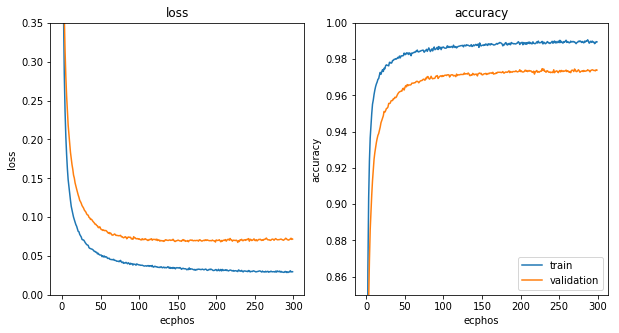

train max acc:0.9908, validation max acc:0.9748, train min loss:0.0287, validation min loss:0.0675
Predicting model total consumed:1.88 seconds
Found 12500 images belonging to 1 classes.


In [3]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 300, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG16')

###  迁移学习-VGG19
- 训练了200代，一共耗时115.76秒，训练集的最高准确率可以到达0.9902，验证集的最高准确率可以到达0.9752
- 预测一共耗时1.86将生成的文件上传至Kaggle得分为0.06498
- 这里只训练200代的原因是，发现200代以后容易出现过拟合的情况

Trainning model total consumed:115.76 seconds


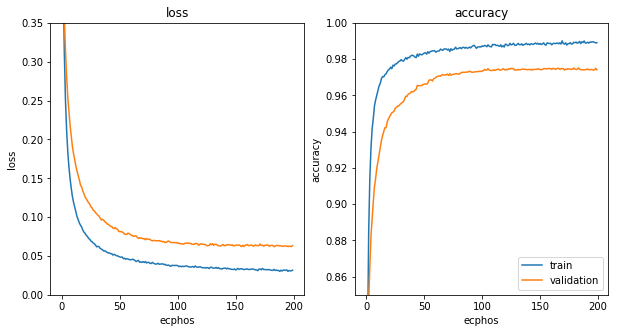

train max acc:0.9902, validation max acc:0.9752, train min loss:0.0301, validation min loss:0.0619
Predicting model total consumed:1.86 seconds
Found 12500 images belonging to 1 classes.


In [6]:
bottleneck_files = ["bottleneck_features/VGG19_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 200, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG19')

###  迁移学习-ResNet50
- 训练了50代，训练一共耗时45.58秒，训练集的最高准确率可以到达0.9940，验证集的最高准确率可以到达0.9826
- 预测一共耗时0.39秒，最后将生成的文件上传至Kaggle得分为0.05707
- 这里只训练50代的原因是，发现50代以后容易出现过拟合的情况

Trainning model total consumed:45.58 seconds


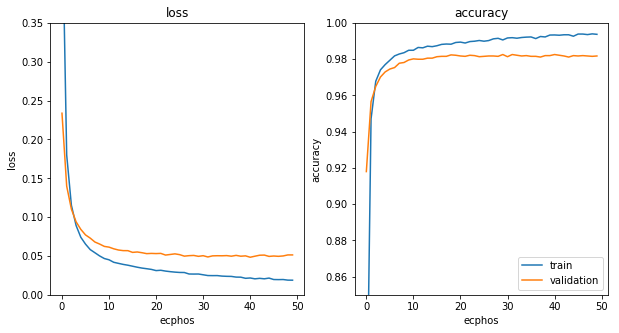

train max acc:0.9940, validation max acc:0.9826, train min loss:0.0188, validation min loss:0.0484
Predicting model total consumed:0.39 seconds
Found 12500 images belonging to 1 classes.


In [8]:
bottleneck_files = ["bottleneck_features/ResNet50_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'ResNet50')

###  迁移学习-InceptionV3
- 训练了15代，训练一共耗时14.50秒，训练集的最高准确率可以到达0.9934，验证集的最高准确率可以到达0.9938
- 预测一共耗时14.50秒，最后将生成的文件上传至Kaggle得分为0.04494

Trainning model total consumed:14.50 seconds


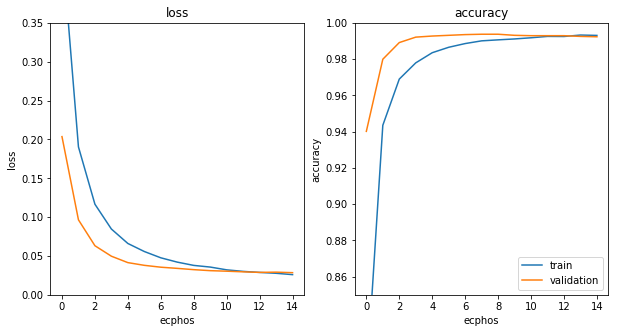

train max acc:0.9934, validation max acc:0.9938, train min loss:0.0260, validation min loss:0.0285
Predicting model total consumed:0.45 seconds
Found 12500 images belonging to 1 classes.


In [14]:
bottleneck_files = ["bottleneck_features/InceptionV3_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 15, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'InceptionV3')

###  迁移学习-Xception
- 训练了15代，训练一共耗时16.02秒，训练集的最高准确率可以到达0.9939，验证集的最高准确率可以到达0.9938
- 预测一共耗时0.5秒，最后将生成的文件上传至Kaggle得分为0.04410

Trainning model total consumed:16.02 seconds


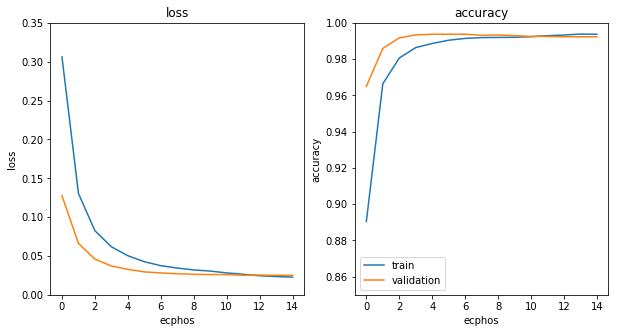

train max acc:0.9939, validation max acc:0.9938, train min loss:0.0228, validation min loss:0.0251
Predicting model total consumed:0.50 seconds
Found 12500 images belonging to 1 classes.


In [19]:
bottleneck_files = ["bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 15, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'Xception')

###  迁移学习-集成所有模型的属性
- 训练了15代，训练一共耗时17.17秒，训练集的最高准确率可以到达0.9961，验证集的最高准确率可以到达0.9934
- 预测一共耗时0.67秒，最后将生成的文件上传至Kaggle得分为0.03944

Trainning model total consumed:17.17 seconds


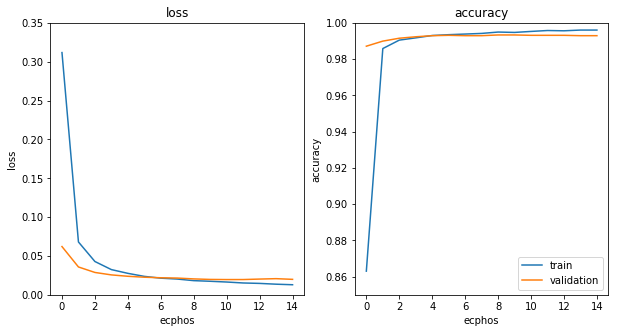

train max acc:0.9961, validation max acc:0.9934, train min loss:0.0130, validation min loss:0.0196
Predicting model total consumed:0.67 seconds
Found 12500 images belonging to 1 classes.


In [20]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5",
                    "bottleneck_features/VGG19_bottleneck_features.h5", 
                    "bottleneck_features/ResNet50_bottleneck_features.h5",
                    "bottleneck_features/InceptionV3_bottleneck_features.h5",
                    "bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 15, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'All_models')